
📊 SVM Metrics:
   Metric    Score
 Accuracy 0.988372
Precision 0.987952
   Recall 1.000000
 F1-Score 0.993939
  ROC AUC 0.783537


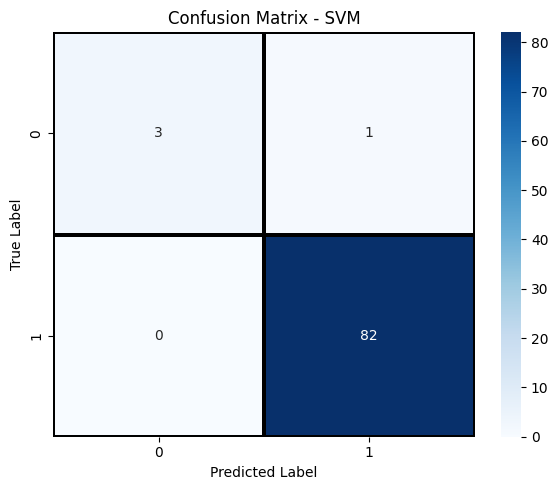

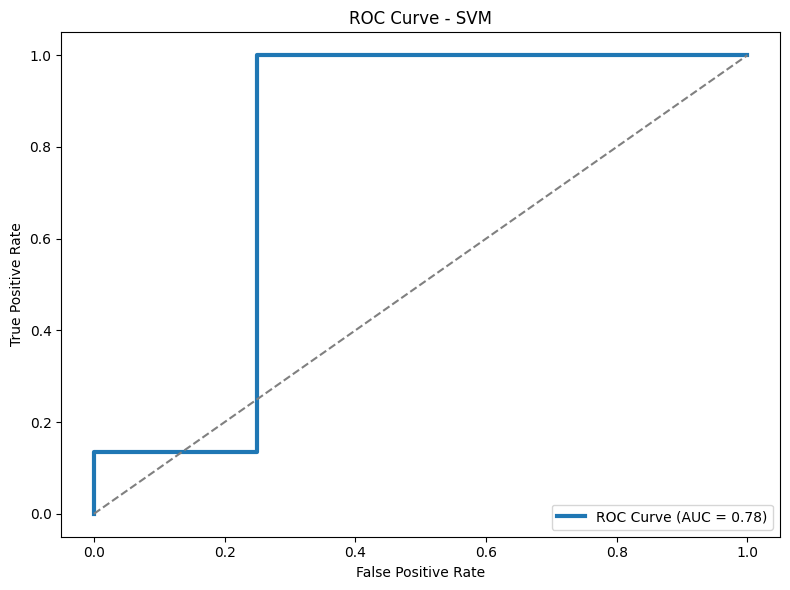


📊 Logistic Regression Metrics:
   Metric    Score
 Accuracy 0.976744
Precision 0.987805
   Recall 0.987805
 F1-Score 0.987805
  ROC AUC 0.942073


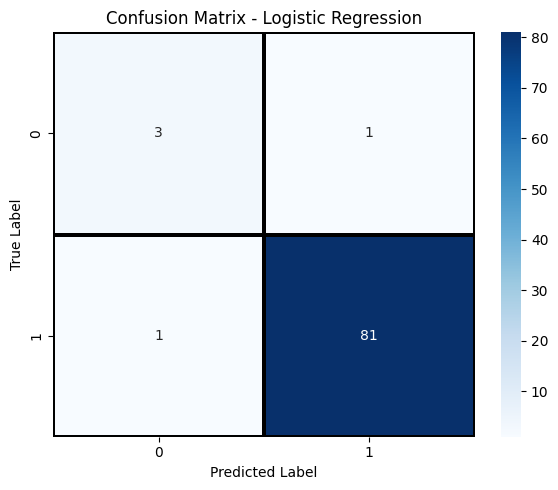

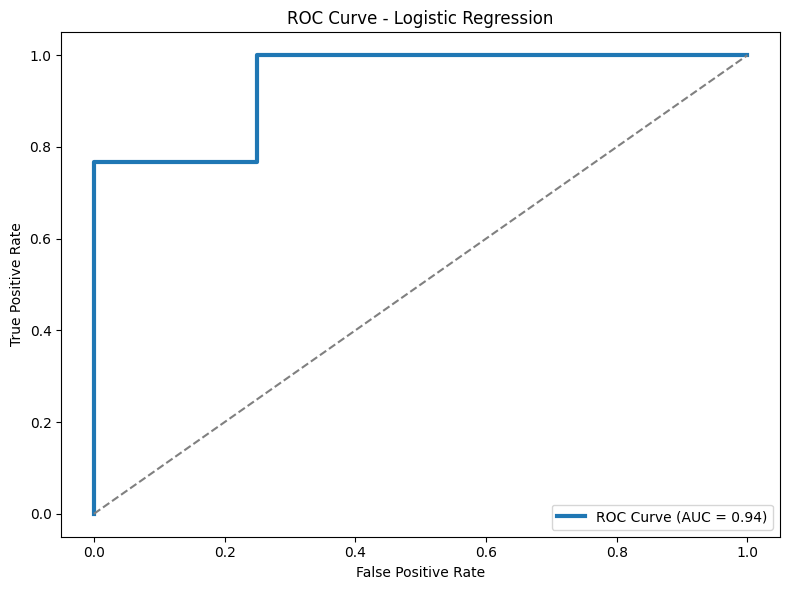


📊 Random Forest Metrics:
   Metric    Score
 Accuracy 0.988372
Precision 0.987952
   Recall 1.000000
 F1-Score 0.993939
  ROC AUC 0.981707


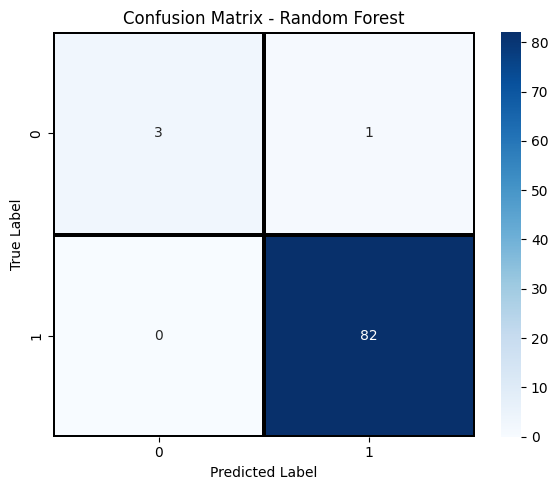

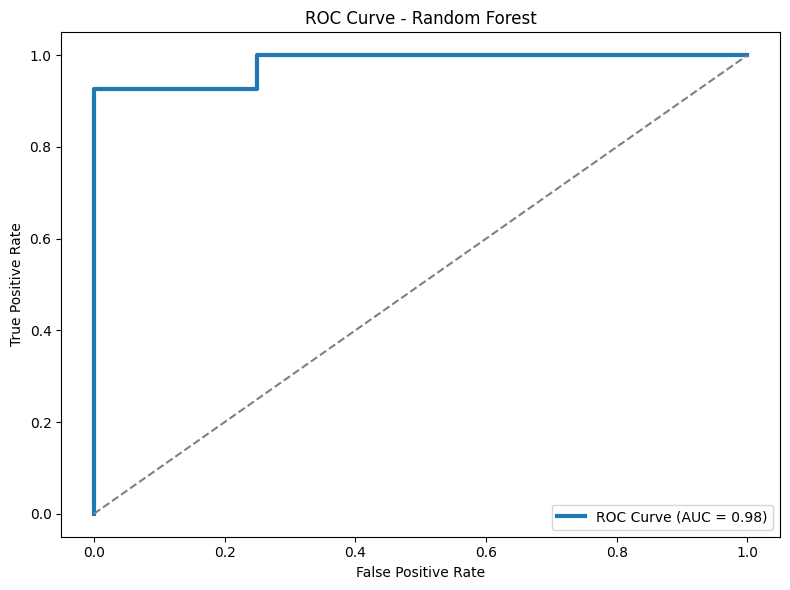

C:\Users\hp\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning: [23:38:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 XGBoost Metrics:
   Metric    Score
 Accuracy 0.976744
Precision 0.987805
   Recall 0.987805
 F1-Score 0.987805
  ROC AUC 0.978659


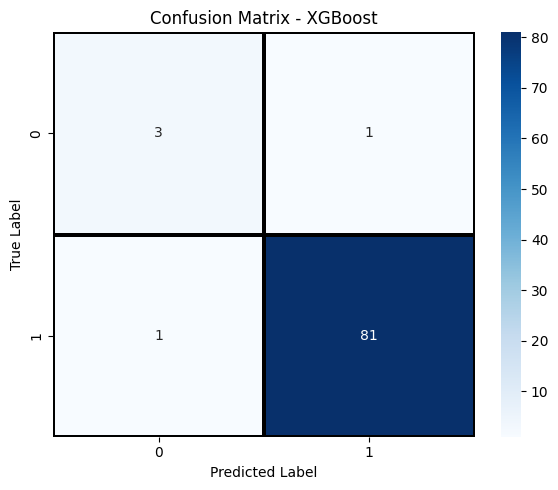

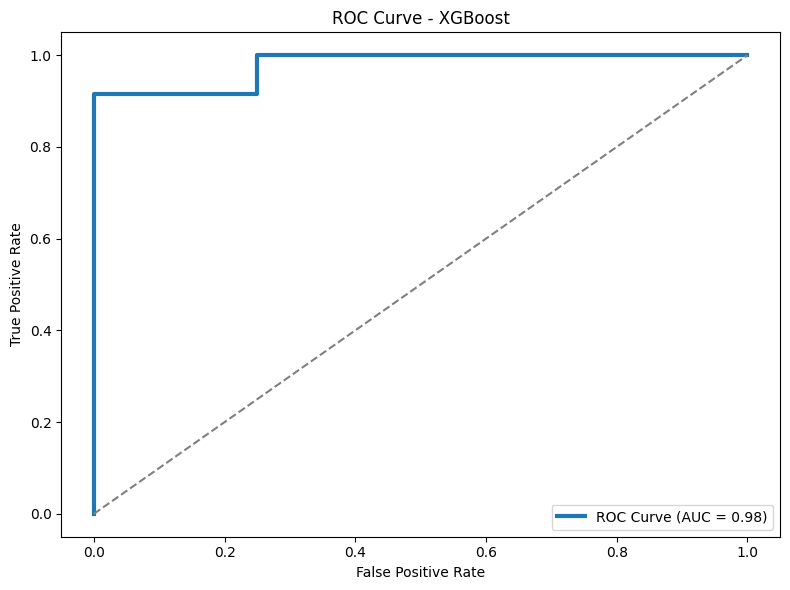

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

# Load preprocessed dataset
df = pd.read_excel("preprocessed_data.xlsx")

# Separate components
features = df.drop(columns=["genes", "LABEL"])
target = df["LABEL"]
sample_names = df["genes"]

# Remove highly correlated features
corr_matrix = features.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
features_reduced = features.drop(columns=to_drop)

df_reduced = pd.concat([sample_names, features_reduced, target], axis=1)
df_reduced.to_excel("reduced_data.xlsx", index=False)

# ---------------------------#
# Model Training and Evaluation
# ---------------------------#
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve,
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
)
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Load feature-selected dataset
df = pd.read_excel("reduced_data.xlsx")
X = df.drop(['genes', 'LABEL'], axis=1)
y = df['LABEL']

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_scaled, y_train)

def evaluate_model(name, model):
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    y_probs = model.predict_proba(X_test_scaled)[:, 1]

    print(f"\n📊 {name} Metrics:")
    metrics_table = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC'],
        'Score': [
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred, zero_division=0),
            recall_score(y_test, y_pred, zero_division=0),
            f1_score(y_test, y_pred, zero_division=0),
            roc_auc_score(y_test, y_probs)
        ]
    })
    print(metrics_table.to_string(index=False))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=1.5, linecolor='black')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_probs)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_probs):.2f})', lw=3)
    plt.plot([0,1], [0,1], color='gray', linestyle='--')
    plt.title(f'ROC Curve - {name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Train and evaluate all models
evaluate_model("SVM", SVC(probability=True, random_state=42))
evaluate_model("Logistic Regression", LogisticRegression(random_state=42))
evaluate_model("Random Forest", RandomForestClassifier(random_state=42))
evaluate_model("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
